This notebook includes a sample script to run simulations of branching and annihilating random walks that are explored in the manuscript "Theory of branching morphogenesis by local interactions and global guidance". A detailed description of the simulation setup can be found in the supplementary file of the published manuscript.

In [1]:
import numpy as np
from numpy import *
from numpy import random
from numpy import linalg as LA
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pylab import *
from timeit import Timer

from matplotlib.collections import LineCollection
from matplotlib.cm import get_cmap
from tqdm import tqdm

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font',size=20)
rc('font',family='serif')
rc('axes',labelsize=20)

We initialize the simulation box and the variables to be updated in the loop:

In [3]:
# Define the dimensions of the simulation box
Lx = 200
Lz = 300

# Elongation length (step size)
lstep = 1

# minimum branching angle
min_branch = pi/10

# Define a distance function between two nodes
def distance(vect,tip):
    diff = np.add(vect[:2],-tip[:2])
    distance = LA.norm(diff)
    return distance

# cutoff length for annihilation via tip-node contact
cutoff = 1.5*lstep
# Radius and strength of attraction/repulsion (if fav<0, then attraction)
radavoid = 10*lstep

x_ind = 0
z_ind = 1
genID = 2
branchID = 3
radiusID = 4

def init(r_init):
    global node, angle, angle_list, coordinates, evolve, radiusList

    node = np.array([[0,Lz/2,0,1,r_init]])
    angle_init = [0.0]
    angle = np.array(angle_init)
    angle_list = np.array([[0,0]])
    diff = 0
    evolve = np.array([len(node)])
    coordinates = np.array([node[0]])    
#     radiusList = [r_init]

The following function defines the transition probabilities modified by the external field strength during elongation:

In [4]:
def prob_list(x,f,pb):
    # bias for forward steps
    alpha = np.clip((1-f*np.sin(x))/2,0,1)
    # bias for backward steps 
    beta = np.clip((1+f*np.sin(x))/2,0,1)

    # list of stepping probabilities:
    problist = np.array([(1-pb)*alpha,(1-pb)*beta,pb*alpha,pb*beta])
    # 'cumulative' probabilities of the list
    cum_prob = [0]+[sum(problist[:j+1]) for j in range(len(problist))]
    
    probs = {'problist':problist,'cumulative':np.array(cum_prob)}
    
    return probs

The following function when evaluated in a loop will generate branched networks with assigned coordinates and angle values:

In [13]:
# Simulation for branching with annihilation, self-avoidance and external guidance

# prob_branch : branching probability, fav : self-avoidance strength, fchem : external field strength

def tissue1(prob_branch,fav,fchem):
    '''
    node: contains the [x,y,genID,branchID] of the tips only
    angle: contains the [\phi, branchID] of the tips only
    coordinates: contains the [x,y,genID,branchID] of every point of the branches
    angle_list: contains the [\phi, branchID] of every points of the branches
    
    
    '''
    
    
    global node, angle, angle_list, coordinates, evolve, radiusList

    skip =0 

    # draw random numbers to decide on next jumps:
    rnr = rand(len(angle))
    
    # determine the cumulative distribution of the stepping probabilities:
    # (use angle values from the local angle list to impose parallel field as guidance)
    cumprob = np.array([prob_list(np.radians(item),fchem,prob_branch)['cumulative'] for item in angle_list[-(len(angle)):,0]])
    # determine the first entry of cumprob that is larger than rnr, and take the entry before that:
    index_rnr = np.array([np.where(cumprob[j]>rnr[j])[0][0]-1 for j in range(len(rnr))])

    node_temp = coordinates[-int(evolve[-1]):]

    for j in range(len(index_rnr)):
        coord_temp = np.append(coordinates,np.array(node),axis=0)
        # highest tree label of existing nodes
        topnr = max(coord_temp[:,3])

        # elongation happens for the first two entries of the cumulative dist:
        if index_rnr[j] == 0:
            # determine a random elongation angle
            # change the angle and coordinates of active tips
            ang_elong = np.random.uniform(0,min_branch)
            # the first entry of cumulative distribution cooresponds to a forward step, i.e. increase the local angle!
            angle[j+skip] += ang_elong
            node[j+skip] = [node[j+skip][0]+lstep*cos(angle[j+skip]),\
                            node[j+skip][1]+lstep*sin(angle[j+skip]),node[j+skip][2],node[j+skip][3],node[j+skip][4]]   
        elif index_rnr[j] == 1:
            # determine a random elongation angle
            # change the angle and coordinates of active tips
            ang_elong = np.random.uniform(0,min_branch)
            # the second entry of cumulative distribution cooresponds to a backward step, i.e. decrease the local angle!
            angle[j+skip] -= ang_elong
            node[j+skip] = [node[j+skip][0]+lstep*cos(angle[j+skip]),\
                            node[j+skip][1]+lstep*sin(angle[j+skip]),node[j+skip][2],node[j+skip][3],node[j+skip][4]]  
            
        # branching happens for the last two entries of the cumulative dist:
        elif index_rnr[j] >= 2:
            # determine two random angles between pi/10 and pi/2:
            ang_branch1 = np.random.uniform(min_branch,pi/2)
            ang_branch2 = np.random.uniform(min_branch,pi/2)
            # add a new branch changing the coordinates with the random angle ang_branch1:
            angle = np.insert(angle,j+skip+1,angle[j+skip]+ang_branch1)
            node = np.insert(node,j+skip+1,[node[j+skip][0]+lstep*cos(angle[j+skip+1]), \
                             node[j+skip][1]+lstep*sin(angle[j+skip+1]),node[j+skip][3],topnr+2, node[j+skip][4]/(2)**(1/3)],axis=0)
            # change the angle and coordinates of the remaining branch with the random angle ang_branch2: 
            angle[j+skip] = angle[j+skip]-ang_branch2
            node[j+skip] = [node[j+skip][0]+lstep*cos(angle[j+skip]), \
                            node[j+skip][1]+lstep*sin(angle[j+skip]),node[j+skip][3],topnr+1,node[j+skip][4]/(2)**(1/3)]
            skip += 1
    
    # Make a list of local angle (\varphi) values BEFORE avoidance or guidance:
    angle = (angle+pi) % (2*pi) - pi 
    
    for j in range(len(node)):
        
        # self-avoidance rules (apply only if there is avoidance potential):
        if fav!=0:
            tip = node[j]

            # determine the distances between the active tip and inactive nodes
            dist = np.add(tip,-coordinates)

            # ignore distances between active tip and parent nodes, as well as within the same duct and sister branches
            for k in range(len(dist)):
                if tip[genID]==coordinates[k,branchID] or tip[branchID]==coordinates[k,branchID] or tip[genID]==coordinates[k,genID]:
                #if tip[-2]==coordinates[k,-1] or tip[-1]==coordinates[k,-1] or tip[-2]==coordinates[k,-2]:
                    dist[k] = [0,0,0,0]
                # ignore distances above avoidance potential
                norm = LA.norm(dist[k][:2])
                if norm > radavoid:
                    dist[k] = [0,0,0,0]

            # sum of the distances within radavoid for the active tip
            dist_sum = np.array(np.sum(dist[:,:2],axis=0))
            # normalized vector and the final displacement vector weighted by a factor 'fav'
            norm_dis = LA.norm(dist_sum)
            if norm_dis > 0:
                displace = np.array(dist_sum/norm_dis)
            else:
                displace = np.array([0,0])

            pol = -fav*displace

            tip[0] += pol[0]
            tip[1] += pol[1]

            for k in range(len(node_temp)):
                # filter only displaced nodes
                if pol[0]!=0 and pol[1]!=0:
                    # calculate distance between the displaced node and its previous instance or its parent
                    if tip[branchID]==node_temp[k][branchID] or tip[genID]==node_temp[k][branchID]:
                    #if tip[-1]==node_temp[k][-1] or tip[-2]==node_temp[k][-1]:
                        displace_more = np.add(tip[:2],-node_temp[k][:2])
                        normalize = LA.norm(displace_more)                    
                        # update node coordinates s.t. normalized distance from previous instance is = 1                    
                        node[j][0] = node_temp[k][0]+displace_more[0]/normalize
                        node[j][1] = node_temp[k][1]+displace_more[1]/normalize
                        # update the angle of the displaced node
                        ydis = node[j][1]-node_temp[k][1]
                        xdis = node[j][0]-node_temp[k][0]
                        if xdis<0:
                            angle[j] = pi + np.arctan(ydis/xdis)
                        else:
                            angle[j] = np.arctan(ydis/xdis)

    # tip annihilation condition:
    skipp = 0

    # list of recent nodes generated in the last 2 time steps
    checklist = [list(item) for item in coordinates[-int(np.sum(evolve[-2:])):]]

    for j in range(len(node)):
        tip = np.array(node[j-skipp])
        once = 0

        # end loop if there are no active tips left         
        if len(node)==0:
            break

        # annihilation due to active tip-passive node contact
        for item in coordinates:
            radius = distance(item[:2],tip[:2])
            # exclude nodes from the same duct, from the parent ..
            # ..if these nodes were generated in the last 2 time steps
            if list(item) in checklist:
                if item[branchID]!=tip[branchID] and item[branchID]!=tip[genID]:
                # if item[-1]!=tip[-1] and item[-1]!=tip[-2]:
                    if 0<radius<cutoff:
                        node = np.delete(node,j-skipp,0)
                        angle = np.delete(angle,j-skipp,0)
                        once = 1
                        skipp += 1
            elif 0<radius<cutoff:
                node = np.delete(node,j-skipp,0)
                angle = np.delete(angle,j-skipp,0)
                once = 1
                skipp += 1
            if once==1:
                break     

    # save the length of node vector (to track node evolution over time)
    evolve = np.append(evolve,len(node))

    # set angle values to be within [-pi,pi]
    angle = (angle+pi) % (2*pi) - pi     
    # save the angles of nodes [in degrees!] including the generation number
    angle_list = np.append(angle_list,np.column_stack((np.degrees(angle),node[:,-1])),axis=0)

    # save the coordinates of all nodes
    coordinates = np.append(coordinates,np.array(node),axis=0) 
    
    
def plotter_basic():

    # Plot simulated network

    fig, ax = plt.subplots(figsize=(4,4))
    ms = 1.5

    # this function can be used to plot the network until a certain time point

    def step(till,evolve):
        step = np.sum(evolve[:till])
        return int(step)

    # choose time1 to plot until a certain timepoint (time1=tmax for the complete network)
    time1 = tmax-1
    time2 = time1+1

    x = [item[0] for item in coordinates[:step(time2,evolve)]]
    y = [item[1] for item in coordinates[:step(time2,evolve)]]


    ax.plot(x,y,'o', color='steelblue', markersize=ms)    
    ax.plot(x[0],y[0],'x',color='firebrick',markersize=8)

    # plot active tips with different color
    ax.plot(x[step(time1,evolve):step(time2,evolve)],y[step(time1,evolve):step(time2,evolve)],'o',color='C1',markersize=ms+1.5)


    plt.tick_params(    
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,   
        left=False,
        labelleft=False,
        labelbottom=False) 

    #legend(fontsize=16,loc=2)

    # set axes limits and labels
    # xlim(-120,380);
    # ylim(-120,380);

    
def get_R(r_0, genID):
    return r_0* (1/1.3)**(genID/3)

Run a test simulation with selected branching probability $p_b$, self-avoidance parameter $f_s$ and external field strength $f_c$ until a timepoint $t_{max}$ is reached:

In [6]:
t = 0
tmax = 300
prob_branch = 0.03
fav = -0.1*0
fchem = 0.6
r_init = 1.0
  
    
init(r_init)    
for t in tqdm(range(tmax), desc="Simulation Progress"):
    if t<5 and len(node)>1:
        break
    if len(node)!=0:
        tissue1(prob_branch,fav,fchem)
    if len(node)==0:
        break   

Simulation Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:05<00:00,  4.59it/s]


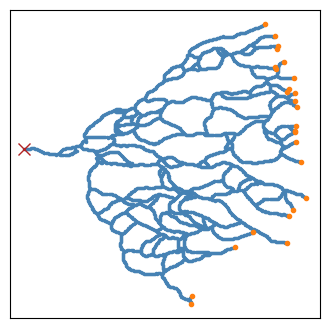

In [7]:
plotter_basic()
plt.savefig("BARW4.png",bbox_inches='tight')

/tmp/ipykernel_58795/300406916.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10',int(maxBranchID))


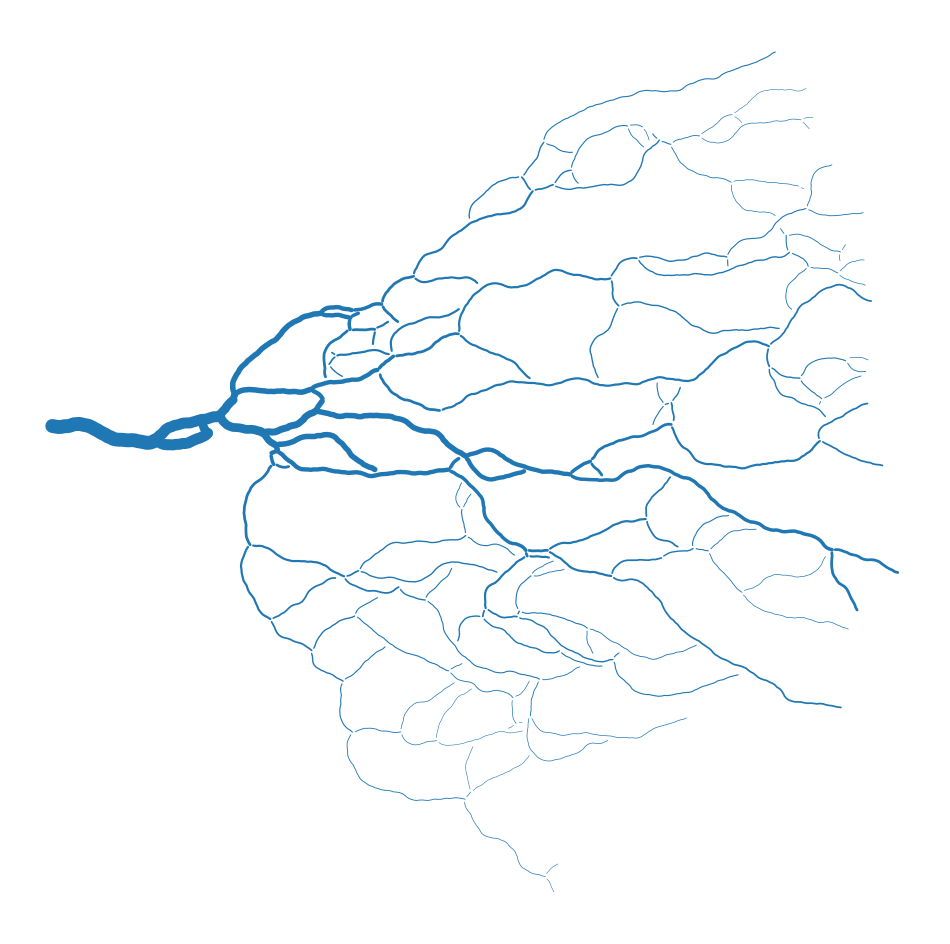

In [8]:
fig = plt.figure(figsize=(12,12))
# gen = np.unique(coordinates[:,branchID])
maxBranchID = np.max(coordinates[:,branchID])
cmap = get_cmap('tab10',int(maxBranchID))
colorList = [cmap(i) for i in range(int(maxBranchID))]
radList = []

for i in range(1,int(maxBranchID)):  ## looping over branchIDs
    coord = coordinates[coordinates[:,3]==i]
    angles = angle_list[angle_list[:,1]==i]
    if len(coord)!= 0:
        color = colorList[int(coord[-1,branchID])]
        color = "C0"
        rad = coord[-1,radiusID]
        radList.append(rad)
        plt.plot(coord[:,0],coord[:,1],c=color,lw=rad*10,solid_capstyle='round',solid_joinstyle='round')
        
# for thisNode in node:
#     plt.plot(thisNode[0],thisNode[1],"o",c="C1",ms=7,solid_capstyle='round')
plt.axis("off")
plt.grid(False)

In [9]:
canvas = FigureCanvas(fig)
canvas.draw()
width, height = fig.get_size_inches() * fig.get_dpi()
image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)



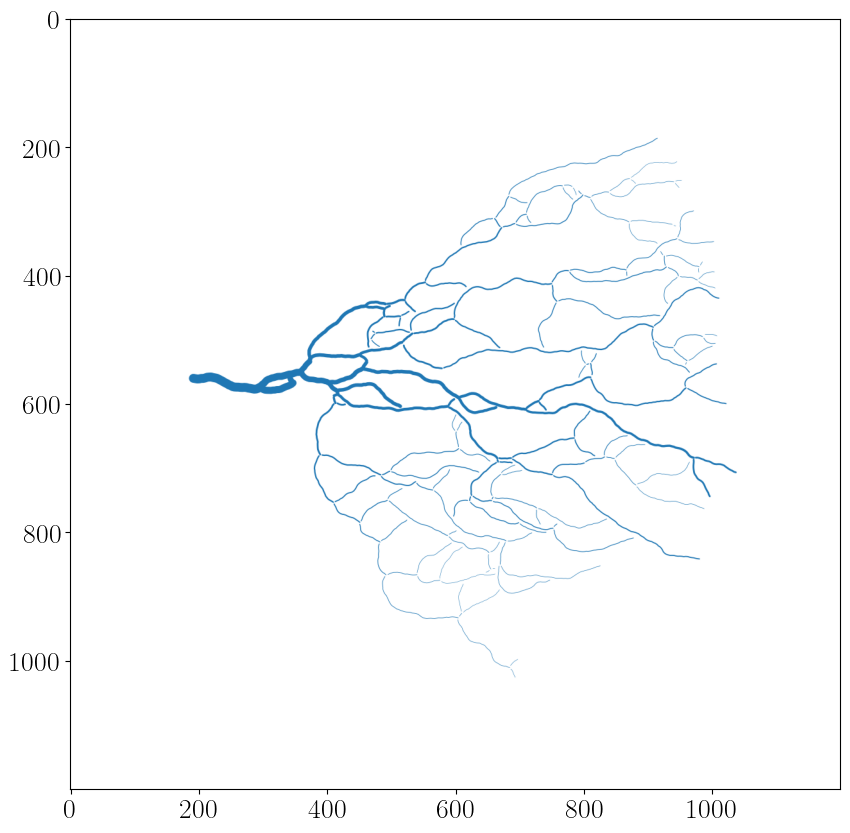

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)

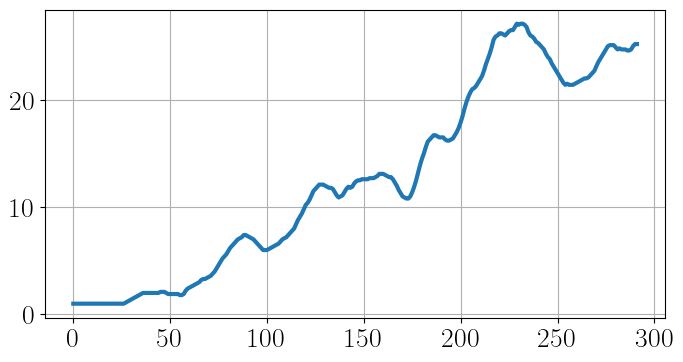

In [11]:
window_size = 10
evolve_smooth = np.convolve(evolve, np.ones(window_size)/window_size, mode='valid')
plt.figure(figsize=(8,4))
plt.plot(evolve_smooth,lw=3)
plt.grid()

Text(0, 0.5, 'Count')

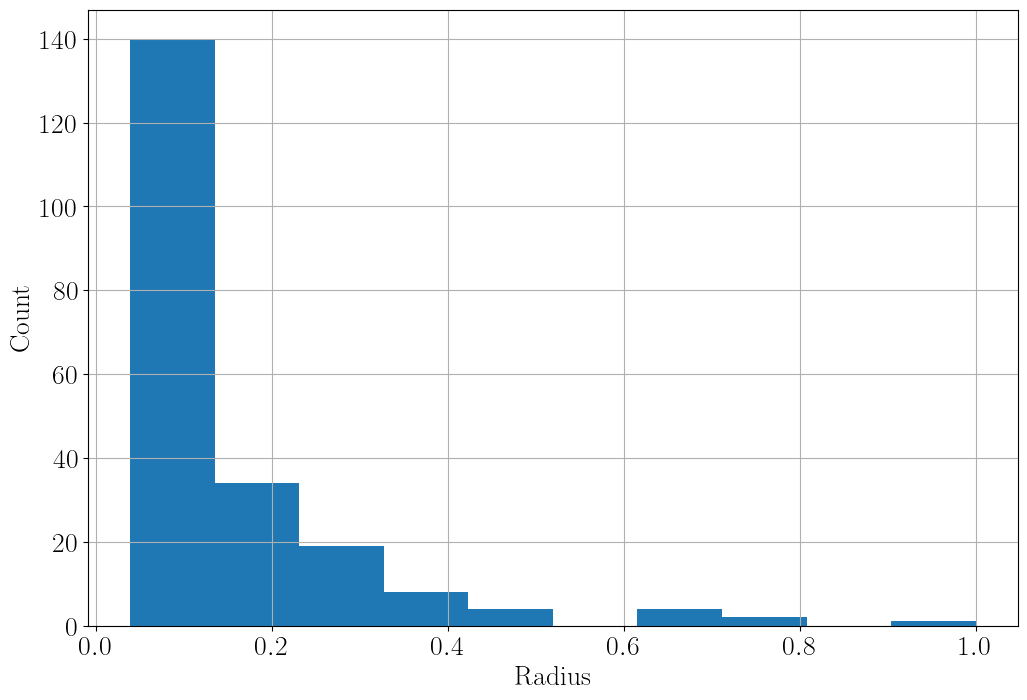

In [12]:
plt.figure(figsize=(12,8))
plt.hist(radList)
plt.grid()
plt.xlabel("Radius")
plt.ylabel("Count")

In [25]:
angle_list.shape

(3800, 2)

## Turning into Graph

In [45]:
network = coordinates[:,:4]
angleList = angle_list

In [55]:
sproutDict = dict()  ## contains the [x,y] position of each branch. The key is branchID
angleDict = dict()  ## contains the angle of each point of each branch. The key is branchID
R = 0 ## The extension length
L_cut = 0 ## the sprouts shorter than this length will be removed
for i in range(1,int(network[-1,-1])):
    coords = network[network[:,-1]==i]
    # angles = angleList[angleList[:,1]==i]
    # if angles.shape[0] > L_cut:
        # extension
        # tipAngle = np.deg2rad(angles[-1,0])
        # dx = R * np.cos(tipAngle)
        # dy = R * np.sin(tipAngle)
        # newPos = coords[-1,:] + np.array([dx,dy,0,0])
        # coords = np.vstack([coords,newPos]) ## These two numbers (-1) will not be recorded in the final dictionary
        
    sproutDict[i] = coords[:,:2]
    # angleDict[i] = np.deg2rad(angles[:,0])


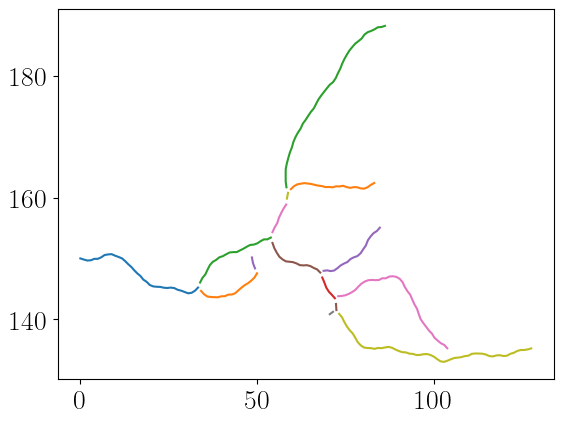

In [59]:
for i in range(1,20):
    plt.plot(sproutDict[i][:,0], sproutDict[i][:,1])

In [57]:
int(network[-1,-1])

117